# TP3: Model Free

### Descripción del código: 

En este Trabajo se les presenta un juego de mesa (una versión simplificada del Perudo: https://www.youtube.com/watch?v=die0n-eonl8, juego que aparece en la pelicula Piratas Del Caribe 2: El cofre de la Muerte). A partir de las reglas de dicho juego se construye un environment.

Además se les brinda un breve código en donde se juega contra dicho environment de forma aleatoria.

Por ultimo, también encontraran dos funciones para graficar la Value function y una política respectivamente.

### Consignas:

1) Implementar el método de Monte Carlo, SARSA y Q-learning para aprender la función valor. Nota: no es necesario, pero si recomendable, usar el esqueleto de funciones que aparecen abajo.

2) Para cada uno de los 3 casos, graficar dicha función valor y la política optima encontrada.

3) Crear un nuevo environment que tome como parámetro una política (dicho parámetro deberá ser la política realizada por la IA). Luego realizar iteraciones para cualquiera de los 3 métodos mencionados, en donde para cada iteración encuentre una política óptima para un jugador que se enfrenta contra la política óptima del paso anterior. Nuevamente graficar la función valor y la política optima final.

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.ytimg.com/vi/gMGsAxuWozQ/maxresdefault.jpg")

In [0]:
import gym
import numpy as np
import random
from gym import spaces
from gym.utils import seeding

## El juego

Reglas:

- 2 jugadores (uno sos vos y una IA)
- Cada jugador cuenta con 5 monedas (cara o cruz). Cada jugador solo ve sus monedas. 
- Después de tirar las monedas, empieza el juego.
- El juego consiste en intentar adivinar al menos cuantas caras hay en total entre todas las monedas o en hacer que el rival adivine incorrectamente.
- La apuesta empieza en 0 caras.
- Se tira una moneda para ver quien de los dos jugadores empieza. 
- Acciones posibles:
    * me quedo con la apuesta hasta ahora y paso.
    * subo en 1 la cantidad de caras que creo que hay en total.
- El juego termina cuando algún jugador pasa.
- Si la apuesta fue mayor al numero real de caras, el apostador pierde (r=-1) y el otro gana. Si la apuesta es menor o igual al numero real, gana el apostados (r=1) y pierde el otro.
- IA inicial de la computadora: Si la apuesta es menor a 2 + cantidad de caras propias, la computadora apuesta. Sino pasa.

In [0]:
# Defino nuestro propio environment con las reglas del juego

def throw_coin(num_coin, np_random):
    return np_random.rand(num_coin)>0.5

def total_faces(list_players):
    RV=0
    for player in list_players:
        RV += sum(player)
    return RV

class PerudoSimplificado(gym.Env):
    def __init__(self):
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), #mis monedas
            spaces.Discrete(10))) #apuesta actual

        self.seed()
        # Empieza el juego
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        if not self.action_space.contains(action):
            print("esta accion no existe:", action)
        assert self.action_space.contains(action)
        
        max_guess_player_2 = total_faces([self.player_2]) + int(len(self.player_1)/2)
        faces_tot = total_faces([self.player_1, self.player_2])
        
        if self.guess > len(self.player_1) + len(self.player_2): #la apuesta es mayor que lo maximo posible
            done = True
            reward = -1

        if action == 0: #action == 0, mantengo la apuesta y paso
            done = True
            if self.guess <= faces_tot: #tenia razon el rival
                reward = -1
            else: #tenia razon yo
                reward = 1
            
        else: #action == 1, subo en 1 la apuesta
            self.guess += 1
            if self.guess < max_guess_player_2: #el rival sube 1 en su turno
                self.guess += 1 
                done = False
                reward = 0
            else: # el rival pasa
                done = True
                if self.guess <= faces_tot:
                    reward = 1
                else:
                    reward = -1
            
        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return (sum(self.player_1), self.guess)
    
    def reset(self):
        self.player_1 = throw_coin(5,self.np_random)
        self.player_2 = throw_coin(5,self.np_random)
        self.guess = 1 if np.random.rand()>0.5 else 0 #al principio se tira una moneda para ver quien empieza. Por eso es 0 (uno empieza) o 1 (empezo el otro y subio)  
        return self.get_obs()

## Jugando al azar

In [0]:
env = PerudoSimplificado()
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(5), Discrete(10))
Discrete(2)


In [0]:
#Politica Random:
for i_episode in range(5):
    state = env.reset()
    print(state, sum(env.player_2))
    print('Juegan!')
    while True:
        action = env.action_space.sample() # Selecciona una accion random dentro de las posibles
        print(state, action)
        state, reward, done, info = env.step(action) # Juega un paso
        #print(state, action)
        if done:
            print('El juego ha terminado! Su reward: ', reward)
            print('Ganaste :)\n') if reward > 0 else print('Perdiste :(\n')
            break

(3, 0) 2
Juegan!
(3, 0) 1
(3, 2) 0
El juego ha terminado! Su reward:  -1
Perdiste :(

(2, 1) 0
Juegan!
(2, 1) 0
El juego ha terminado! Su reward:  -1
Perdiste :(

(3, 1) 1
Juegan!
(3, 1) 0
El juego ha terminado! Su reward:  -1
Perdiste :(

(3, 1) 1
Juegan!
(3, 1) 1
(3, 3) 1
El juego ha terminado! Su reward:  1
Ganaste :)

(4, 0) 4
Juegan!
(4, 0) 0
El juego ha terminado! Su reward:  -1
Perdiste :(



## Graficos:

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_values(V):
    """
    Realiza un grafico en 3 dimensiones de la función valor.
        
    El parametro V es un diccionario cuyas keys son pares "caras en mi mano" 
    y "apuesta actual".
    """
    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('caras en tu mano')
        ax.set_ylabel('apuestas')
        ax.set_zlabel('value')
        ax.view_init(ax.elev, -120)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    get_figure(ax)
    plt.show()

In [0]:
def plot_policy(policy):
    """
    Realiza un grafico en 3 dimensiones de la función valor.
    
    El parametro policy es un diccionario cuyas keys son pares "caras en mi mano" 
    y "apuesta actual" y el valor es la acción ha realizar.
    """
    def get_Z(x, y):
        if (x,y) in policy:
            return policy[x,y]
        else:
            return 25 # este valor "25" es para visualizar que la policy no tiene asignada una acción para dicho estado.

    def get_figure( ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(0, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y) for x in x_range] for y in y_range])
        surf = ax.imshow(np.flip(Z,0), cmap=plt.get_cmap('Pastel2', 3), vmin=0, vmax=2, extent=[-0.5, 5.5, -0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('caras en mi mano')
        ax.set_ylabel('apuestas')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1,2], cax=cax)
        cbar.ax.set_yticklabels(['0 (pasar)','1 (subir)', 'desconocido'])
        print(Z)
            
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    get_figure(ax)
    plt.show()

In [0]:
def init_Q(mis_caras=6, apuesta_actual=11, nA=2):
    """
    Esta función arma un diccionario anidado donde las primeras llaves son cuántas
    caras tengo yo, y las llaves anidadas son la apuesta actual y tiene como valor
    una lista donde cada posicion es la Q para la accion correspondiente
    Los valores que hay que pasarle son:
    mis_caras=6
    apuesta_actual=11
    nA=2
    """
    Q = {}
    for i in range(mis_caras):
        for j in range(apuesta_actual):
            Q[(i,j)] = np.zeros((nA,)) # Valor de Q para la acción 0 y para la acción 1
            
    return Q

## Monte Carlo

In [0]:
def get_probs(Q_s, epsilon, nA): 
    # A partir de Q determinar una policy e-greedy
    policy_s = np.ones(nA) * epsilon / nA
    
    # Elijo la mejor segun Q para ese estado
    best_a = np.argmax(Q_s)

    # desempato
    tied_max = np.argwhere(np.array(Q_s) == np.max(Q_s)).flatten().tolist()
    best_a = int(np.random.choice(tied_max)) if len(tied_max)>1 else best_a
    
    # genero policy
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
   
def generate_episode_from_Q(env, Q, epsilon, nA):
    # inicilizo estado
    state = env.reset()
    episode = []
    while True:
        # genero policy
        policy_s =  get_probs(Q[state], epsilon, nA)
        # elijo accion
        action =  np.random.choice([0,1], p=policy_s) # el [0,1] lo podriamos remplazar con env.action_space
        # juego accion
        state, reward, done, info = env.step(action) # Juega un paso
        # guardo el par estado-accion
        episode.append((state, action))
        if done:
            break
    return (episode, reward)
  
def update_Q(env, episode, Q, alpha, gamma, returns):
    # first-visit 
    states_appeared = []
    reward = episode[1]
    for state, action in episode[0]:
        # agrego a return el reward que corresponde
        returns[state][action].append(reward)
        # promedio los returns para un estado-accion dado
        Q[state][action] = np.mean(returns[state][action])
    return Q, returns

In [0]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=0.5, eps_decay=.999999, eps_min=0.05):
    # Inicio Q
    Q = init_Q(6,11,2)
    nA = 2
    epsilon = eps_start
    returns = dict(zip(Q.keys(), [([],[]) for i in range(len(Q.keys()))]))
    
    for i_episode in range(num_episodes):
        # genero un episodio con la policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update de Q
        Q, returns = update_Q(env, episode, Q, alpha, gamma, returns)
        #actualizar eps
        epsilon = epsilon*eps_decay if epsilon*eps_decay > eps_min else eps_min
    
    policy = {}
    policy_probs = {}
    
    # genero policy obtenida
    for state in Q.keys():
        policy[state] = np.argmax(get_probs(Q[state], epsilon, nA))
        policy_probs[state] = get_probs(Q[state], epsilon, nA)
        
    return policy, Q, policy_probs, returns

1188.3798642158508


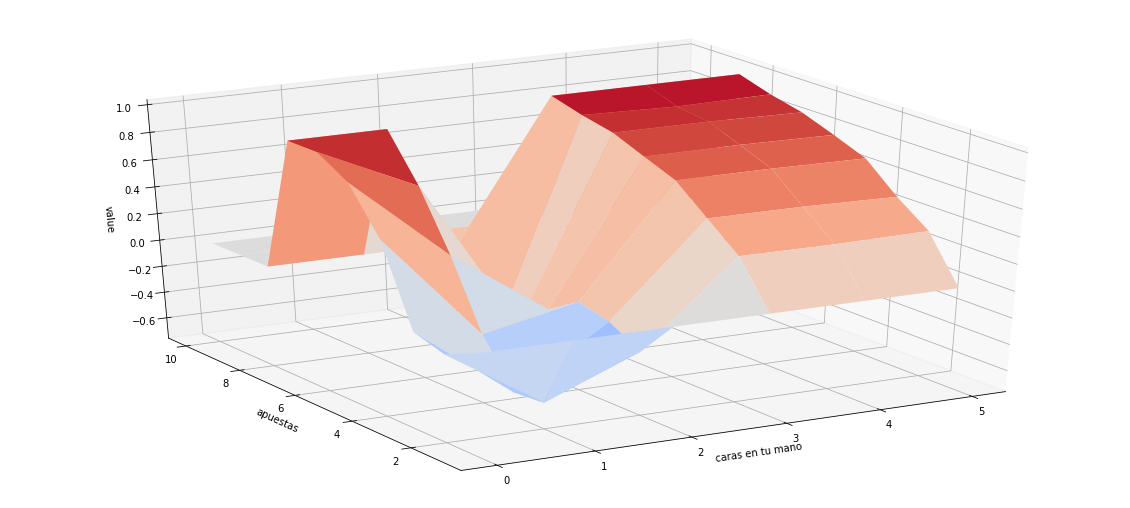

In [0]:
from time import time
# Calcular la politica optima y el value function
inicio = time()
policy, Q, policy_probs, returns = mc_control(env, 500000, 0.001)
print(time()-inicio)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_values(V)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 1 1 1 1 1]
 [1 1 1 0 0 1]]


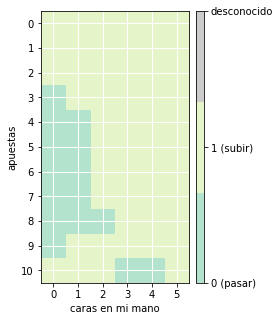

In [0]:
# plotear la politica
plot_policy(policy)

## SARSA

In [0]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    # si la accion no es 0
    if action!=0:
        # regla de update
        Q[state][action] += alpha*(reward + gamma*Q[next_state][next_action] - Q[state][action])
    else:
        # si el estado es terminal Q[next_state] = 0
        Q[state][action] += alpha*(reward - Q[state][action])
    return Q
    
def epsilon_greedy(Q, state, nA, eps):
    # tiro una moneda de peso eps
    if state[1]==10:
        selected_action = 0
    else:    
        sample = np.random.choice([0, 1], p=[eps, 1-eps])
        # elijo al azar
        if sample == 0:
            selected_action = np.random.randint(0, nA)
        else:
            # Elijo de manera greedy'
            tied_max = np.argwhere(Q[state] == np.max(Q[state])).flatten().tolist()
            selected_action = [np.random.choice(tied_max) if len(tied_max)>1 else tied_max[0]][0]
            selected_action = int(selected_action)
    return selected_action

In [0]:
def sarsa(env, num_episodes, alpha, gamma=1, epsilon = 0.5, eps_decay = 0.9999, epsmin=0.01):
    # Inicio Q
    Q = init_Q(6,11,2)
    
    for i_episode in range(num_episodes):
        # inicio el estado para el episodio
        state = env.reset()
        # actualizo el eps con la regla eps = 1/t
        eps = epsilon/(i_episode + 1) if epsilon/(i_episode + 1) > epsmin else epsmin
        # elijo accion
        action = epsilon_greedy(Q, state, env.action_space.n, eps)
        while True:
            # ejecuto accion
            next_state, reward, done, info = env.step(action)
            # calculo accion epsilon greedy para el siguiente estado
            next_action = epsilon_greedy(Q, next_state, env.action_space.n, eps)
            # update de Q
            Q = update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state, next_action)
            state = next_state
            action = next_action
            if done:
                break
        
    return Q

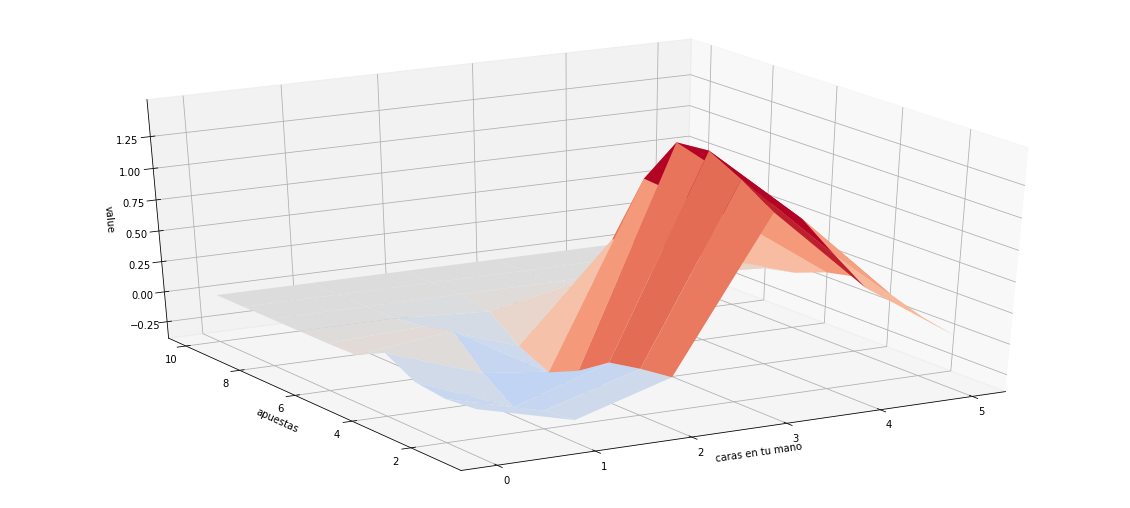

In [0]:
# Calcular la politica optima y el value function
ALPHA = 0.00005
Q_sarsa = sarsa(env, 500000, alpha=ALPHA)
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())
plot_values(V)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


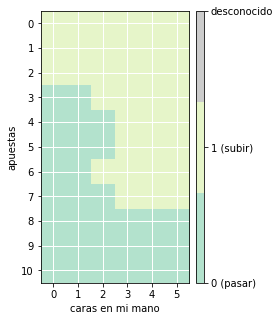

In [0]:
# plotear la politica
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())
plot_policy(policy_sarsa)

## Q-learning

In [0]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    # regla de update
    if action!=0:
        Q[state][action] += alpha*(reward+gamma*np.max(Q[next_state]) - Q[state][action])
    else: # si el estado es terminal Q[next_state] = 0
        Q[state][action] += alpha*(reward - Q[state][action])
    return Q

In [0]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsilon = 0.5, eps_decay = 0.9999, epsmin=0.01): 
    Q = init_Q(6, 11, 2)
    for i_episode in range(num_episodes):
        # genero estado inicial
        state = env.reset()
        while True:
            # actualizo el eps con la regla eps = 1/t
            eps = epsilon/(i_episode + 1) if epsilon/(i_episode + 1) > epsmin else epsmin
            # obtengo accion por epsilon greedy
            action = epsilon_greedy(Q, state, env.action_space.n, eps)
            # ejecuto accion
            next_state, reward, done, info = env.step(action)
            # uso regla de update
            Q = update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state)
            state = next_state
            if done:
                break

    return Q

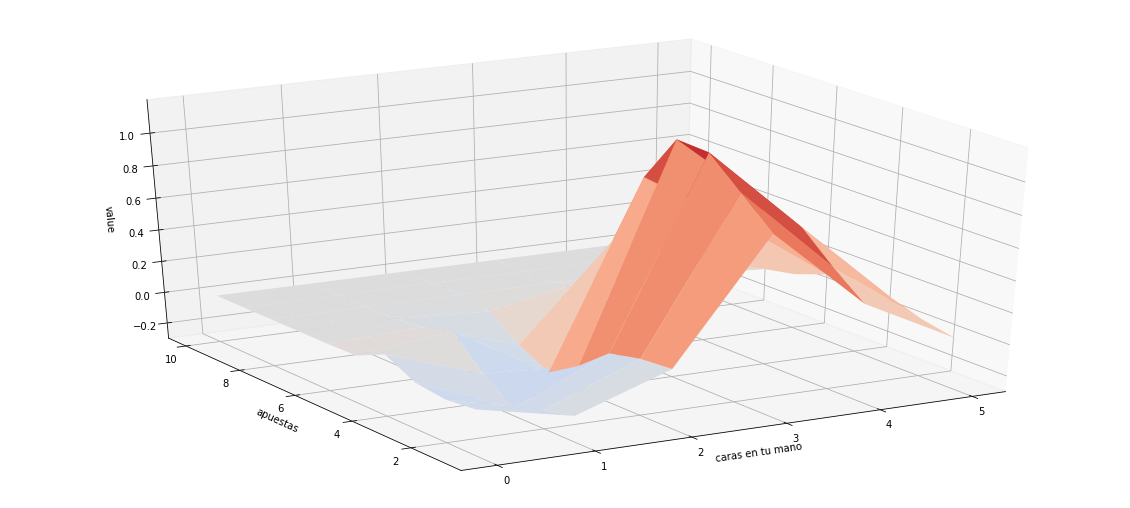

In [0]:
# Calcular la politica optima y el value function
ALPHA = 0.00005
Q_sarsamax = q_learning(env, 350000, alpha=ALPHA)
V = dict((k,np.max(v)) for k, v in Q_sarsamax.items())
plot_values(V)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


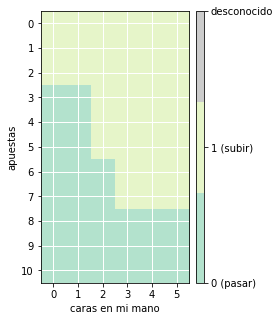

In [0]:
# plotear la politica
policy_sarsamax = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
plot_policy(policy_sarsamax)

## Comentarios

Al ejecutar los distintos algoritmos sobre el juego, se puede apreciar que entre los algoritmos existen ciertas diferencias en cuanto a las políticas encontradas. En particular, se pueden observar mayores diferencias entre las policy de Monte Carlo y Sarsa o Q-learning, que entre las políticas de Sarsa y Q-learning. 

Dadas estas diferencias vinculadas a casos extremos de los estados como por ejemplo en los que las apuestas alcanzan a 10 caras o casos donde el jugador tiene 0 caras o 5 caras, sospechamos que las mismas podrían ser explicadas por falta de exploración de los algoritmos. Para combatir esto intentamos correr mas episodios (en los experimentos utilizamos desde 350.000 hasta 500.000) pero aquí encontramos otros problemas esta vez relacionados con la estimación de Q, en el caso de Sarsa y Q-learning obteniamos resultados sin sentido en los cuales los valores estimados de Q para ciertos estados superaban los valores posibles de Q. Frente a estos problemas intentamos una nueva alternativa que es la de probar distintas actualizaciones del decaimiento de epsilon, sin embargo ninguna de ellas mostró mejorar los resultados. 

Finalmente, para poder encontrar resultados de Q entre -1 y 1 tuvimos que definir valores de alpha muy chicos, haciendo distintas pruebas llegamos a que 0.00005 es un valor razonable que permite realizar entre 350.000 y 500.000 iteraciones sin obtener valores de Q mayores a 1.

Por último, es necesario mencionar encontramos cierta variabilidad en los resultados al cambiar el valor de alpha definido (en los casos de Sarsa y Q-learning).

## Perudo con políticas

In [0]:
policy = [[1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [0, 1, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1],
         [0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]


In [0]:
class PerudoConPolitica(gym.Env):
    def __init__(self, policy):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), #mis monedas
            spaces.Discrete(10))) #apuesta actual
        self.policy = policy
        self.seed()
        # Empieza el juego
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def _get_guess_from_policy(self):
        return self.policy[self.guess][sum(self.player_2)]
        
    def step(self, action):
        if not self.action_space.contains(action):
            print("esta accion no existe:", action)
        assert self.action_space.contains(action)
        
        # max_guess_player_2 = total_faces([self.player_2]) + int(len(self.player_1)/2)
        faces_tot = total_faces([self.player_1, self.player_2])
        
        if self.guess > len(self.player_1) + len(self.player_2): #la apuesta es mayor que lo maximo posible
            done = True
            reward = -1

        if action == 0: #action == 0, mantengo la apuesta y paso
            done = True
            if self.guess <= faces_tot: #tenia razon el rival
                reward = -1
            else: #tenia razon yo
                reward = 1
            
        else: #action == 1, subo en 1 la apuesta
            self.guess += 1
            if self.guess > len(self.player_1) + len(self.player_2): #la apuesta es mayor que lo maximo posible
                player_2_action = 0
            else:
                player_2_action = self._get_guess_from_policy()
            
            if player_2_action == 1: #el rival sube 1 en su turno
                self.guess += 1 
                done = False
                reward = 0
            else: # el rival pasa
                done = True
                if self.guess <= faces_tot:
                    reward = 1
                else:
                    reward = -1
            
        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return (sum(self.player_1), self.guess)
    
    def reset(self):
        self.player_1 = throw_coin(5,self.np_random)
        self.player_2 = throw_coin(5,self.np_random)
        self.guess = 1 if np.random.rand()>0.5 else 0 #al principio se tira una moneda para ver quien empieza. Por eso es 0 (uno empieza) o 1 (empezo el otro y subio)  
        return self.get_obs()

In [0]:
# Estudiamos la convergencia de las policies

def get_policy(policy_dict):
    if isinstance(policy_dict, dict):
      policy_array = np.zeros((11,6))
      for state in policy_dict.keys():
          policy_array[state[1],state[0]] = policy_dict[state]
    else:
      policy_array = policy_dict
    
    # hardcodeo que al final tiene que dar 0
    for i in range(6):
        policy_array[10][i] = 0
    return policy_array
  
def delta_policies(adversarial_policy, env_policy):
    # que tan diferentes son la policy del ambiente y la nueva policy mirando la diferencia total entre ellas
    return abs((get_policy(adversarial_policy) - np.array(env_policy))).sum()

In [0]:
# estudiamos la existencia de una política óptima iterando en este caso con Q-learning, 

ALPHA = 0.009
EPISODES = 80000
IT = 50
act_policy = policy
# almacenamos las políticas óptimas en cada paso
all_policies = []
convergencia = False
iteraciones = 0
while not convergencia:
    if iteraciones % 10 == 0:
        print(iteraciones)
    # establezco la policy del environment
    env = PerudoConPolitica(act_policy)
    # estimo q con Q-learning
    Q_est = q_learning(env, num_episodes=EPISODES, alpha=ALPHA)
    V = dict((k,np.max(v)) for k, v in Q_est.items())
    # calculo la politica
    new_policy = dict((k,np.argmax(v)) for k, v in Q_est.items())
    all_policies.append(new_policy)
    # si consigo que se repita la politica de un paso a otro termino
    if delta_policies(new_policy, act_policy) == 0:
        convergencia = True
        print('Convergió y la política es:')
        plot_policy(new_policy)
    elif iteraciones > IT:
        convergencia = True
        print('No convergió')
    act_policy = get_policy(new_policy)
    iteraciones += 1
    

0
10
20
30
40
50
No convergió


In [0]:
# si no convergio la política, puede ser que tengamos ciclos, por lo cual estudiamos esa posibilidad
import pandas as pd
df = pd.DataFrame(all_policies)

In [0]:
duplicated = df[df.duplicated(keep=False)] # Cantidad de politicas repetidas
duplicated

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(5, 1)","(5, 2)","(5, 3)","(5, 4)","(5, 5)","(5, 6)","(5, 7)","(5, 8)","(5, 9)","(5, 10)"
5,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
8,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
13,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
14,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
17,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
18,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
20,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
21,1,1,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [0]:
duplicated = duplicated.drop_duplicates() # elimino las politicas duplicadas

In [0]:
duplicated = duplicated.T

#### Ploteo politicas encontradas

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


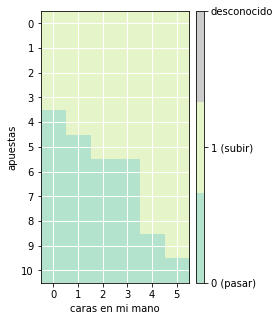

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]


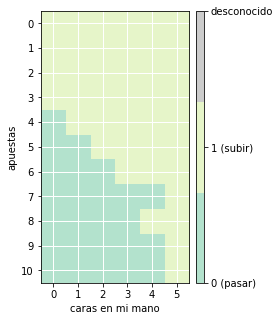

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]


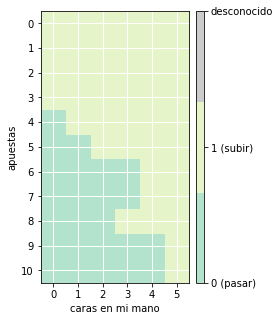

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]


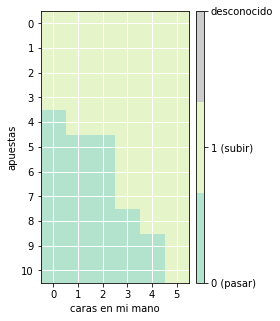

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]]


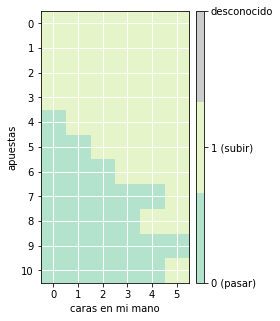

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 0]]


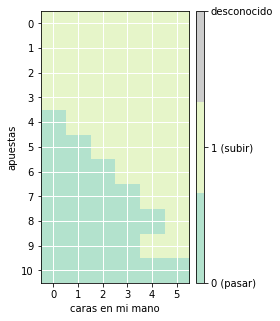

In [0]:
for i in range(len(duplicated.columns)):
    plot_policy(duplicated.iloc[:,i].to_dict())

## Comentarios finales
PerudoConPolitica es un ambiente que toma una política predefinida y la establece como política del ambiente, permitiendonos jugar contra ella. Posteriormente instanciamos este environment con la política obtenida originalmente con  Q-learning. 
Realizamos una simulación en donde se generan varias iteraciones, en cada una se:
- Instancia PerudoConPolitica, con la política óptima aprendida en el paso anterior
- Se usa q-learning para aprender una política óptima contra la política aprendida en el paso anterior
- Se chequea si converge o no, si converge se frena la ejecución
- En caso de no convergencia estiduamos si existen ciclos en las políticas, es decir las politicas comienzan a repetirse constantemente.

En nuestro caso corrimos 50 iteraciones donde para cada iteración utilizamos 80000 simulaciones con Q-learning. Finalmente vemos que ciertas políticas se repiten y no existe una convergencia a una única política óptima sino que existe cierta ciclicidad entre las políticas antes graficadas.